In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [3]:
def show_mask(anns, ax):
    """画像にマスクを被せて表示する
    """
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

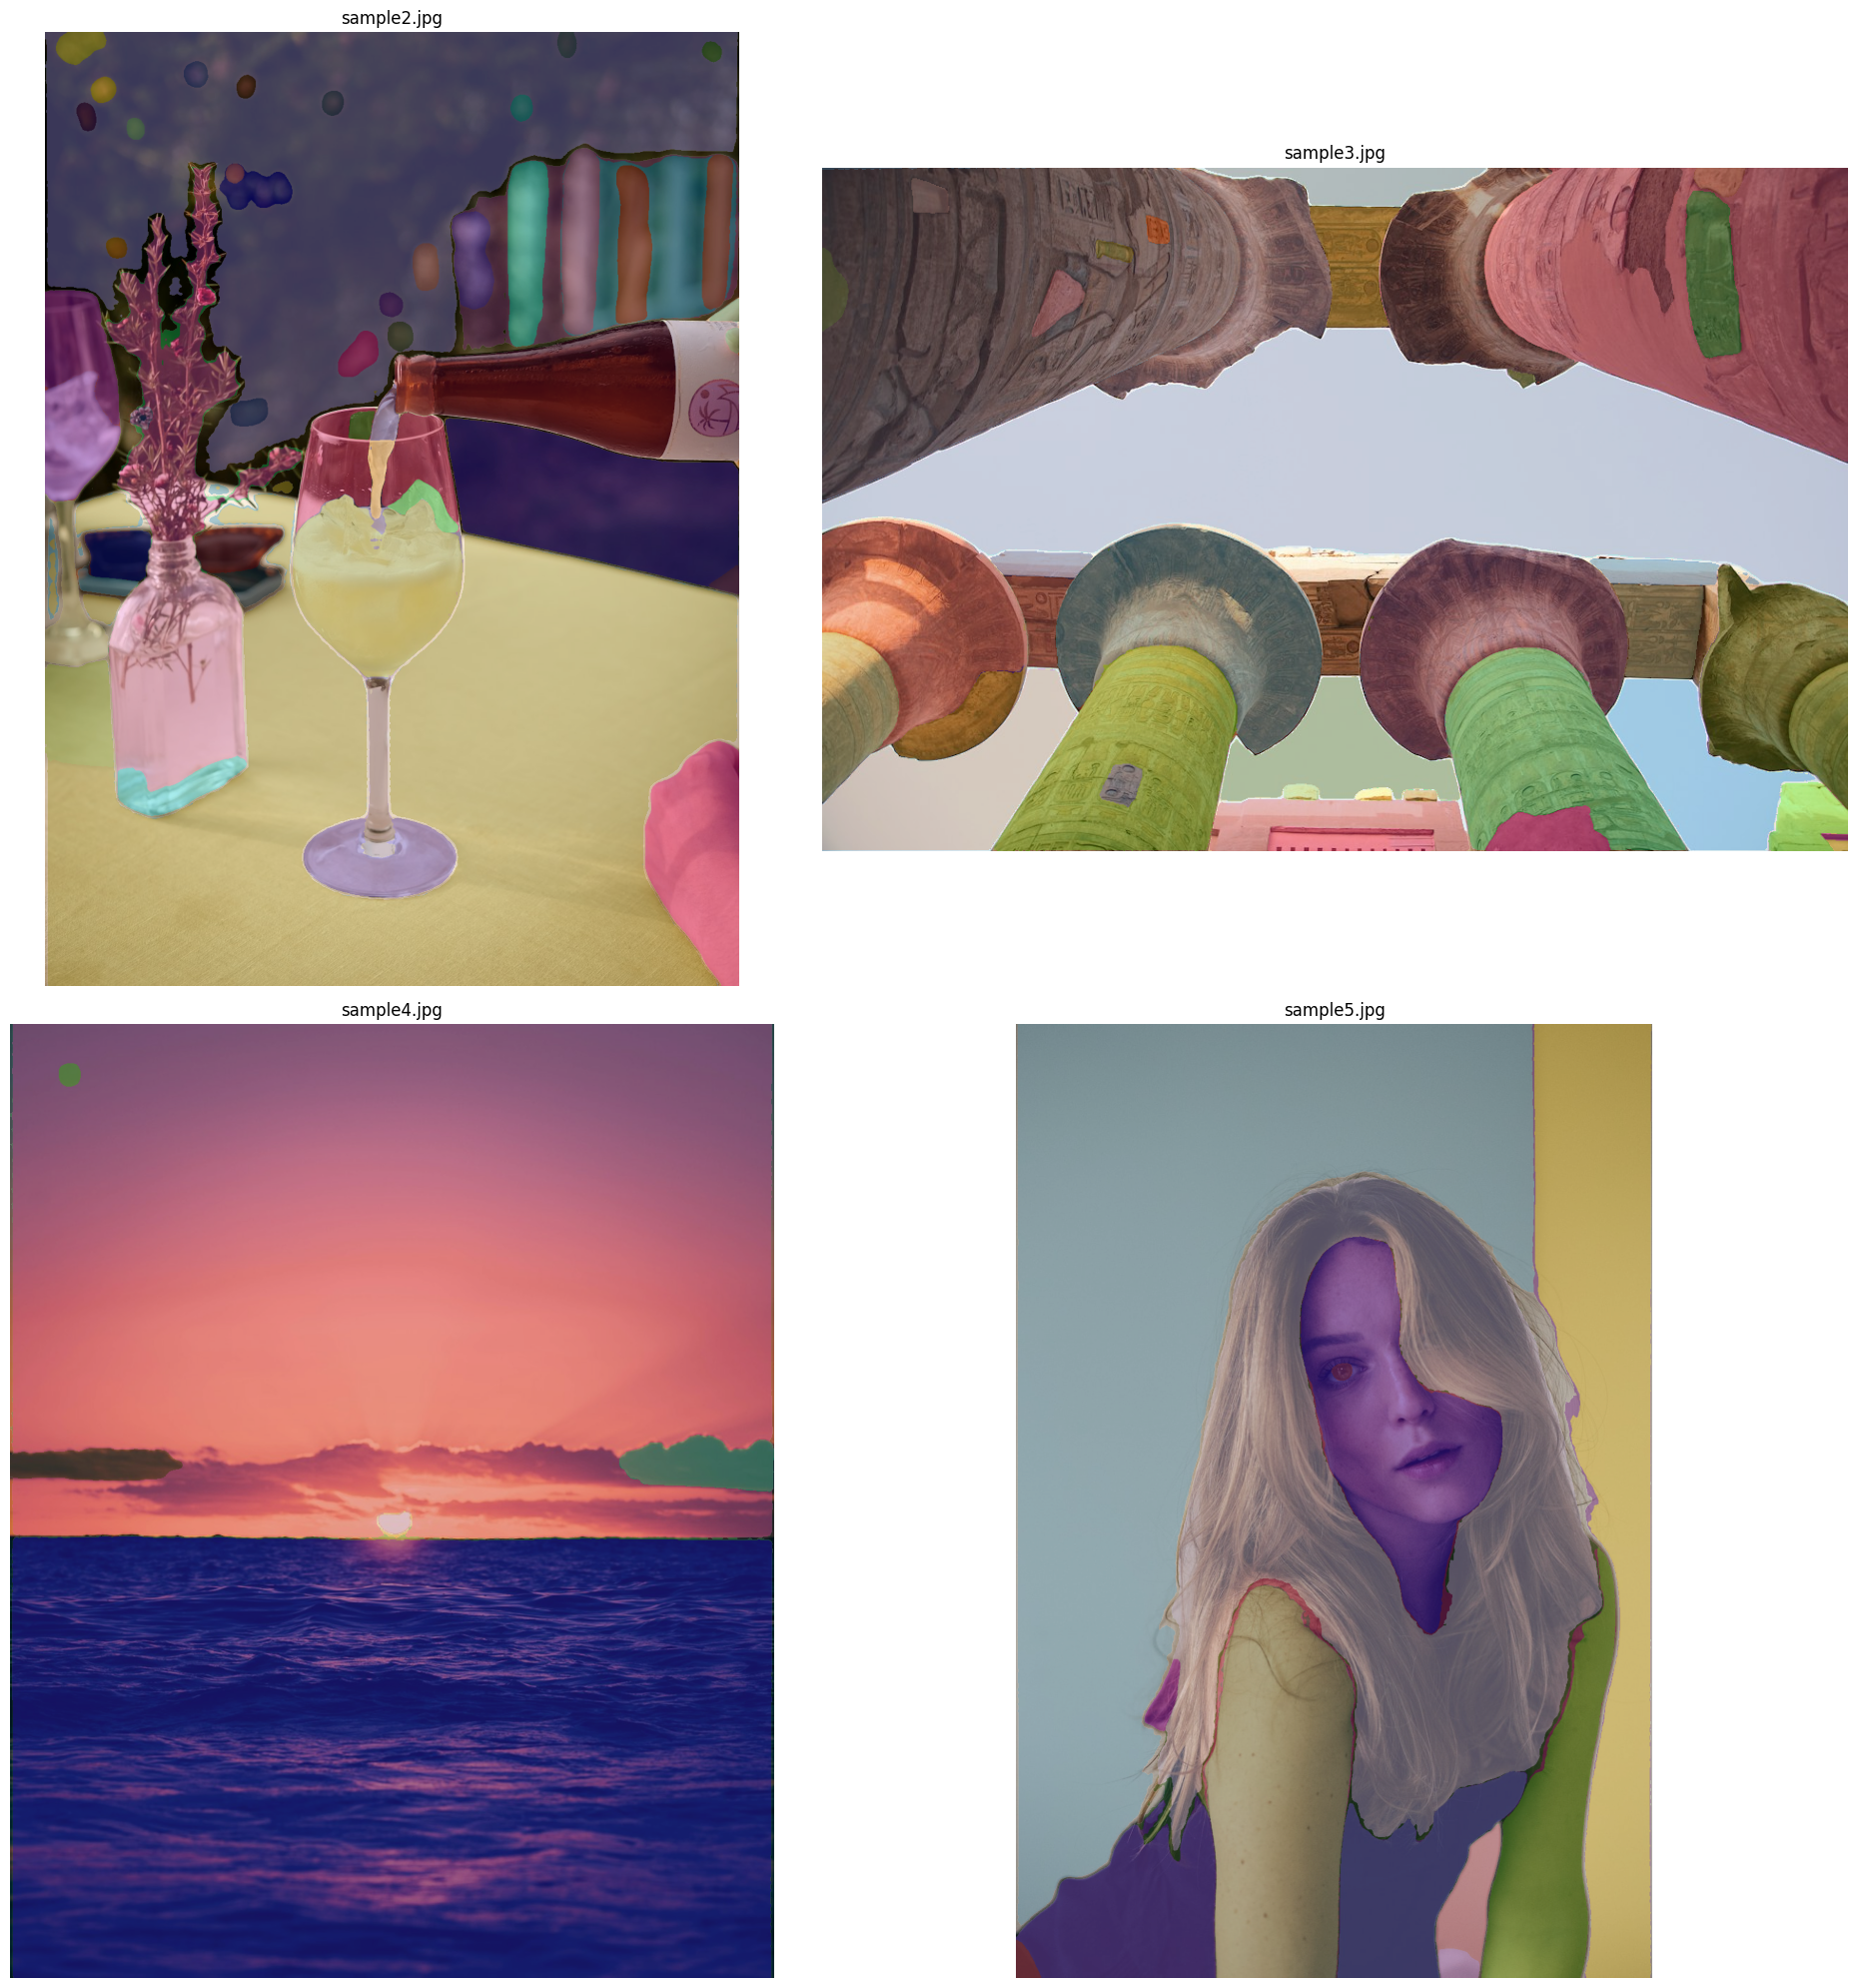

In [4]:
from pathlib import Path
import math


# 画像のパスを取得
image_paths = list(Path("../images/samples").glob("*.jpg"))

# グリッドのサイズを計算（画像の数の平方根を切り上げ）
grid_size = math.ceil(math.sqrt(len(image_paths)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

dataframes = []

for ax, image_path in zip(axs.flatten(), image_paths):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    masks = mask_generator.generate(image)
    df = pd.DataFrame(masks)
    df["file"] = image_path.name
    dataframes.append(df)

    ax.imshow(image)
    show_mask(masks, ax)
    ax.axis('off')
    ax.set_title(image_path.name)

# 余ったサブプロットを非表示にする
for ax in axs.flatten()[len(image_paths):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# データフレームを表示

dataframes[0].head()

,segmentation,area,bbox,predicted_iou,point_coords,stability_score,crop_box,file
0,"[[True, True, True, True, True, True, True, Tr...",393274,"[0, 0, 1077, 686]",1.029649,"[[455.625, 487.265625]]",0.953249,"[0, 0, 1080, 1485]",sample2.jpg
1,"[[False, False, False, False, False, False, Fa...",510991,"[0, 680, 1077, 804]",1.022220,"[[793.125, 812.109375]]",0.979141,"[0, 0, 1080, 1485]",sample2.jpg
2,"[[False, False, False, False, False, False, Fa...",40500,"[933, 1104, 146, 380]",1.014593,"[[995.625, 1276.171875]]",0.987915,"[0, 0, 1080, 1485]",sample2.jpg
3,"[[False, False, False, False, False, False, Fa...",72308,"[99, 787, 214, 432]",1.011454,"[[219.375, 997.734375]]",0.990177,"[0, 0, 1080, 1485]",sample2.jpg
4,"[[False, False, False, False, False, False, Fa...",14976,"[0, 403, 115, 208]",1.005943,"[[84.375, 533.671875]]",0.979561,"[0, 0, 1080, 1485]",sample2.jpg


### Area が最大のものを抽出して比較

In [6]:
pd.DataFrame([df.loc[df["area"].idxmax()] for df in dataframes]).sort_values("file")

,segmentation,area,bbox,predicted_iou,point_coords,stability_score,crop_box,file
15,"[[False, False, False, False, False, False, Fa...",514402,"[3, 108, 1074, 1376]",0.975006,"[[16.875, 1136.953125]]",0.954598,"[0, 0, 1080, 1485]",sample2.jpg
4,"[[False, False, False, False, False, False, Fa...",234261,"[0, 0, 1079, 717]",1.009062,"[[16.875, 371.25]]",0.980018,"[0, 0, 1080, 720]",sample3.jpg
2,"[[False, False, False, False, False, False, Fa...",1441436,"[0, 0, 1077, 1349]",1.029873,"[[523.125, 738.28125]]",0.974030,"[0, 0, 1080, 1350]",sample4.jpg
0,"[[False, False, False, False, False, False, Fa...",881434,"[3, 261, 1015, 1358]",1.039513,"[[894.375, 1493.4375]]",0.991682,"[0, 0, 1080, 1620]",sample5.jpg


### Area が最小のものを抽出して比較

In [7]:
pd.DataFrame([df.loc[df["area"].idxmin()] for df in dataframes]).sort_values("file")

,segmentation,area,bbox,predicted_iou,point_coords,stability_score,crop_box,file
31,"[[False, False, False, False, False, False, Fa...",706,"[281, 206, 28, 30]",0.962424,"[[286.875, 208.828125]]",0.985896,"[0, 0, 1080, 1485]",sample2.jpg
52,"[[False, False, False, False, False, False, Fa...",181,"[1052, 701, 27, 7]",0.928344,"[[1063.125, 708.75]]",0.956989,"[0, 0, 1080, 720]",sample3.jpg
4,"[[False, False, False, False, False, False, Fa...",856,"[69, 57, 30, 32]",0.963786,"[[84.375, 63.28125]]",0.989559,"[0, 0, 1080, 1350]",sample4.jpg
18,"[[False, False, False, False, False, False, Fa...",853,"[535, 577, 35, 29]",0.895028,"[[556.875, 582.1875]]",0.978035,"[0, 0, 1080, 1620]",sample5.jpg


### 行数 = オブジェクト数の比較

In [8]:
for df in dataframes:
    print(f"{len(df)} - {df.loc[0]['file']}")

66 - sample2.jpg
60 - sample3.jpg
8 - sample4.jpg
19 - sample5.jpg
